In [1]:
from residual_learning.utils import (
                BaseForecaster, 
                ResidualForecasterDarts,
                TimeSeriesPreprocessor,
)
import pandas as pd
import matplotlib.pyplot as plt
import os
from darts import TimeSeries
from darts.metrics import smape
import numpy as np
import time

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
targets = pd.read_csv("targets.csv.gz")

In [3]:
targets["site_id"].unique()

array(['ARIK', 'BARC', 'BIGC', 'BLDE', 'BLUE', 'BLWA', 'CARI', 'COMO',
       'CRAM', 'CUPE', 'FLNT', 'GUIL', 'HOPB', 'KING', 'LECO', 'LEWI',
       'LIRO', 'MART', 'MAYF', 'MCDI', 'MCRA', 'OKSR', 'POSE', 'PRIN',
       'PRLA', 'PRPO', 'REDB', 'SUGG', 'SYCA', 'TECR', 'TOMB', 'TOOK',
       'WALK', 'WLOU'], dtype=object)

Below cell will preprocess data for all the sites whereby gaps in data are filled. This performs GP fits which are time intensive, so this will take a while to execute. One could parallelize with Ray, but since it takes around 6 hours to complete, I just ran it overnight. Skip a few cells below if you want to load from a csv.

In [4]:
data_preprocessor = TimeSeriesPreprocessor()
start = time.time()
for site in targets["site_id"].unique():
    data_preprocessor.preprocess_data(site)
print(time.time() - start)

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consi

4365.592260837555


In [5]:
data_preprocessor.save()

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consi

Alternatively, loading CSV's.

In [4]:
data_preprocessor = TimeSeriesPreprocessor()
data_preprocessor.load()

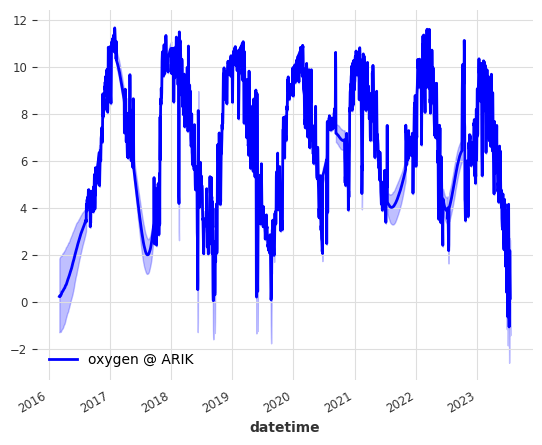

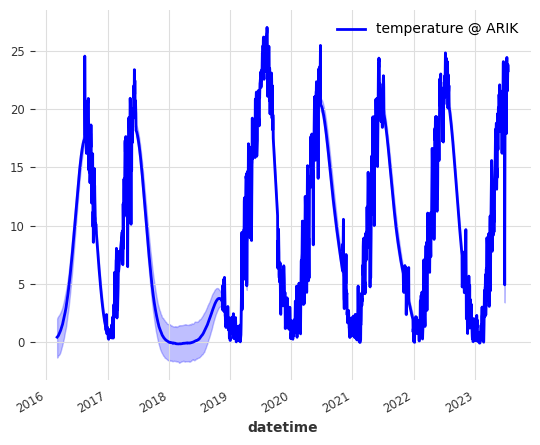

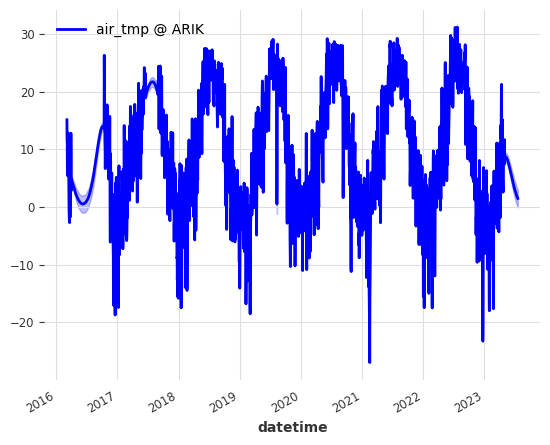

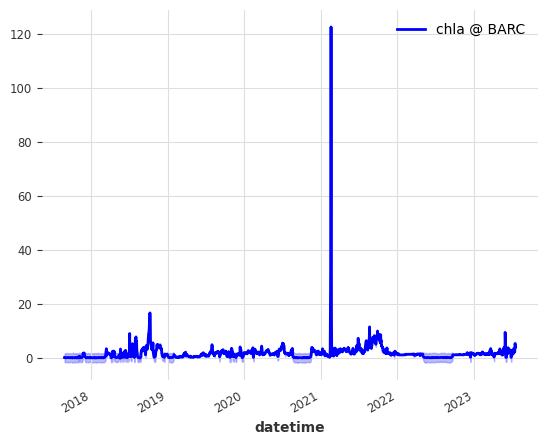

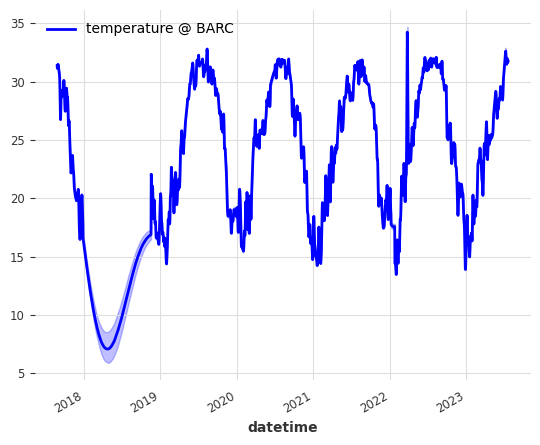

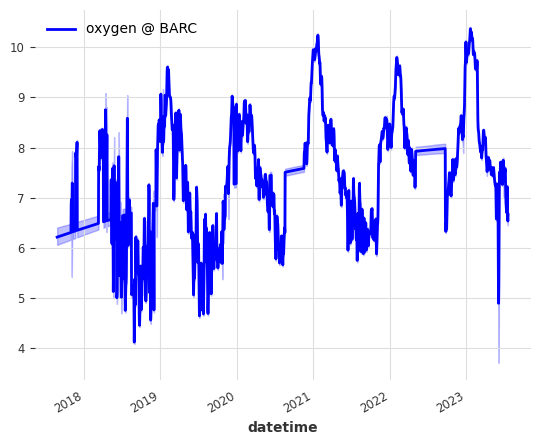

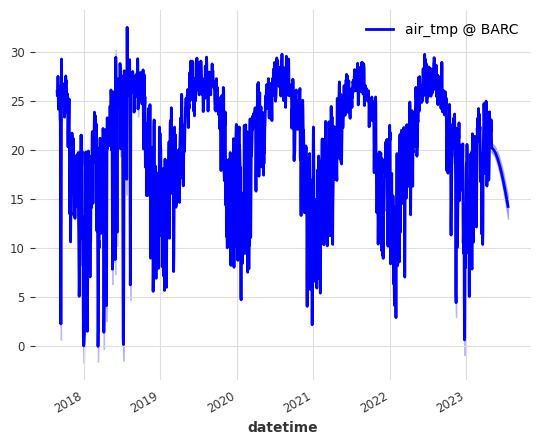

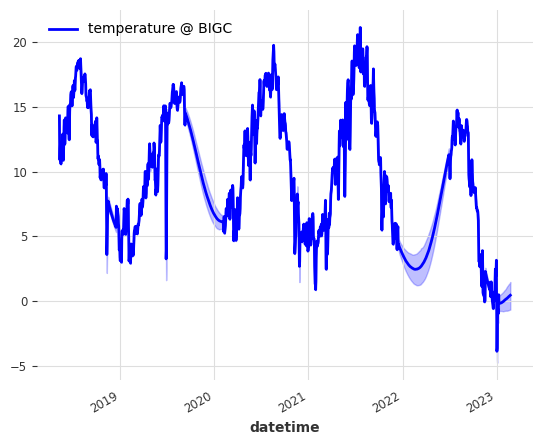

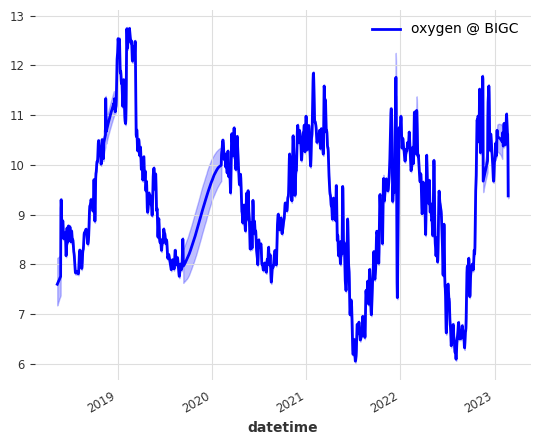

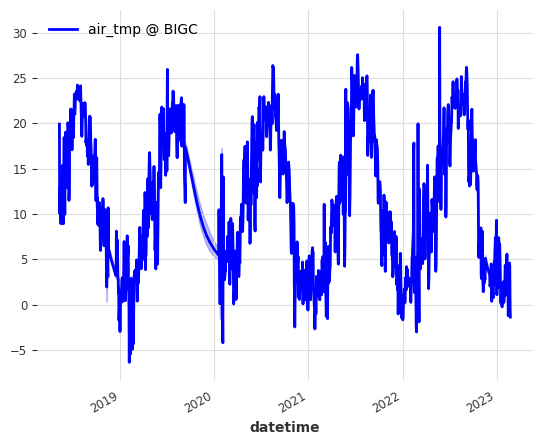

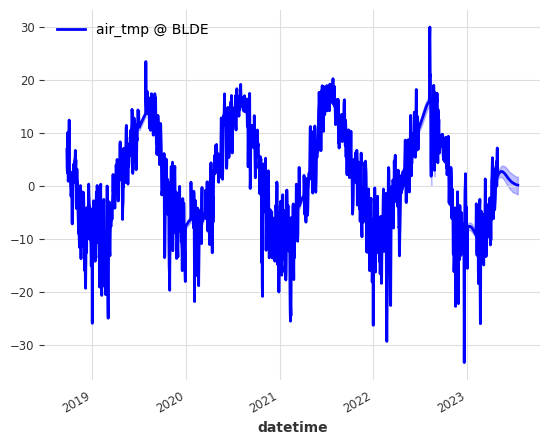

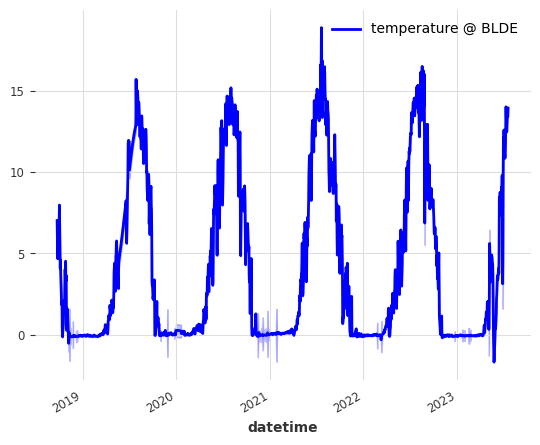

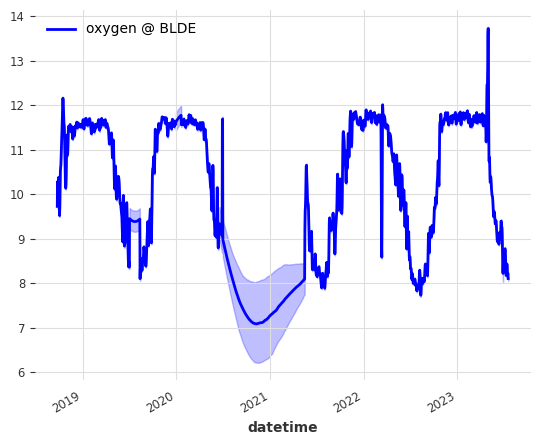

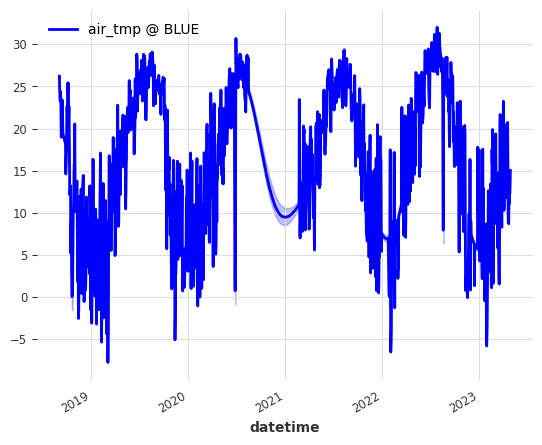

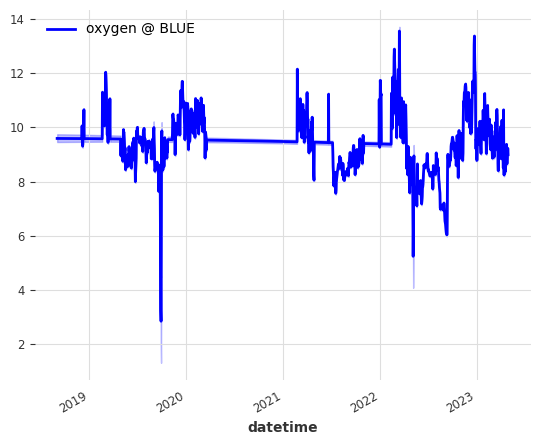

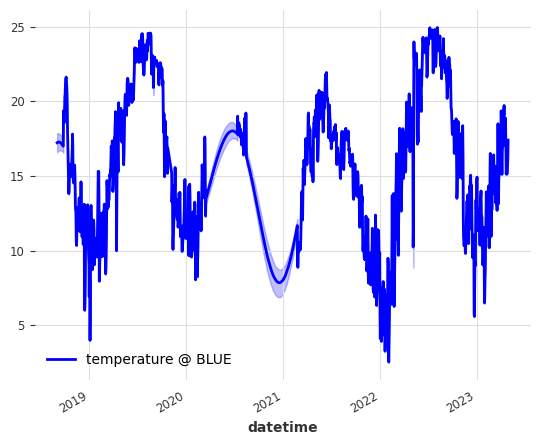

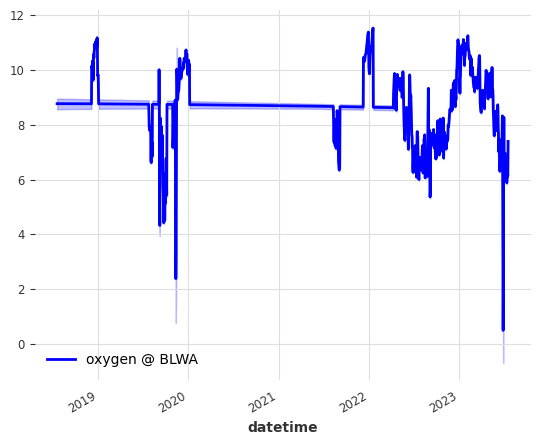

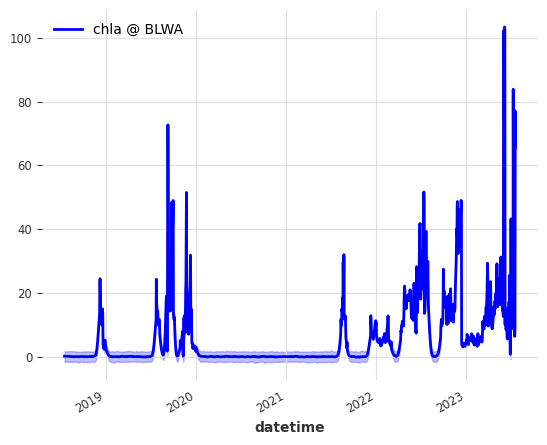

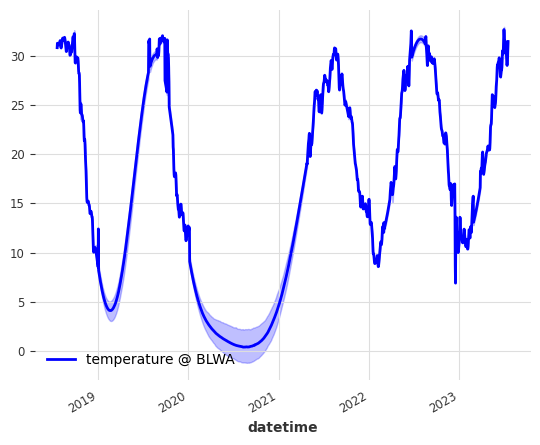

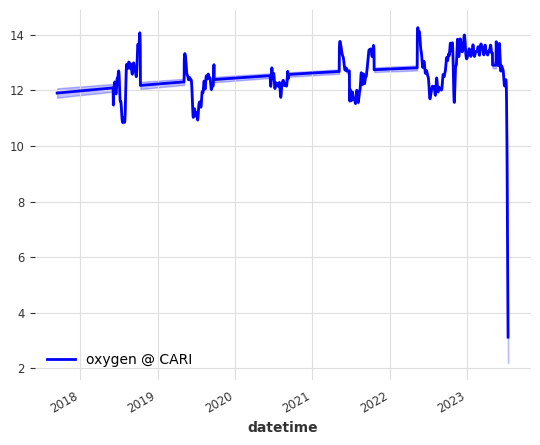

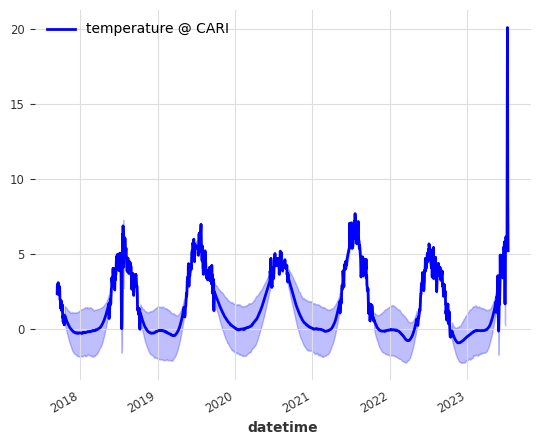

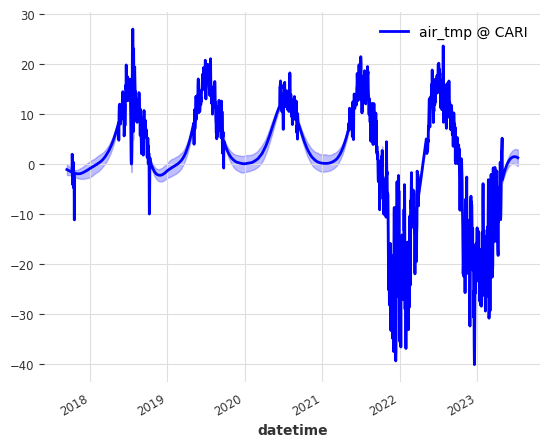

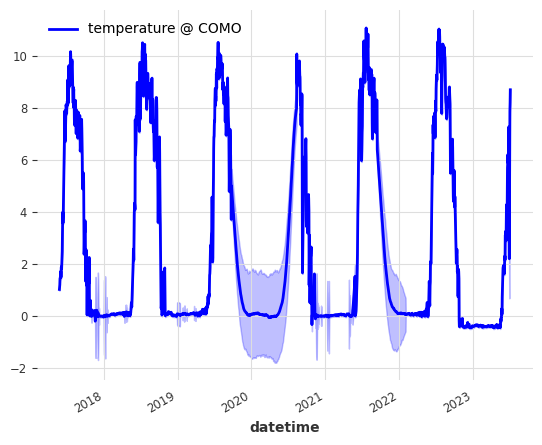

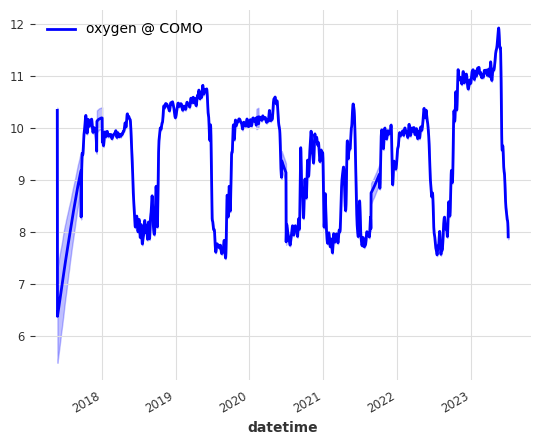

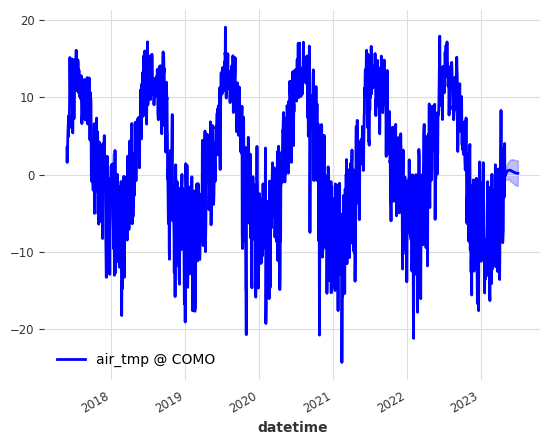

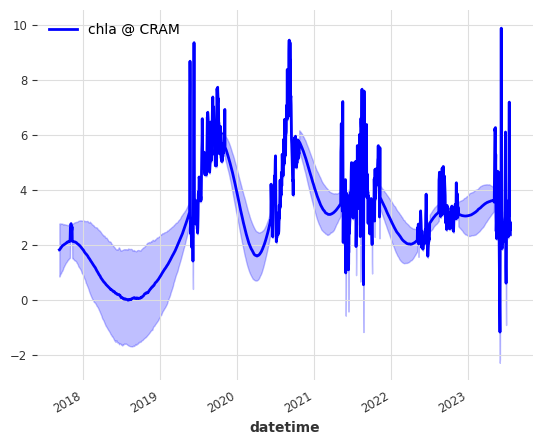

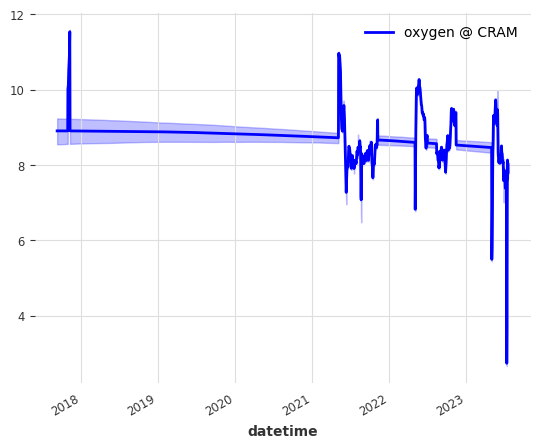

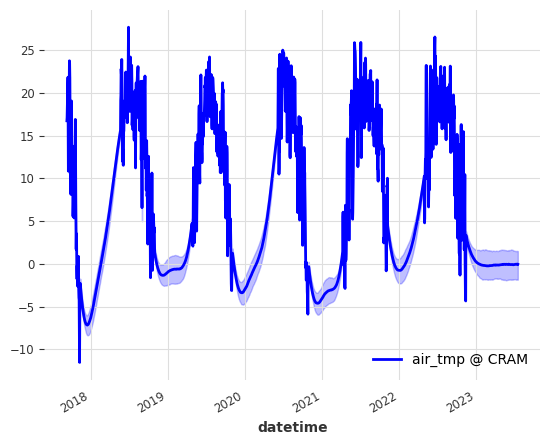

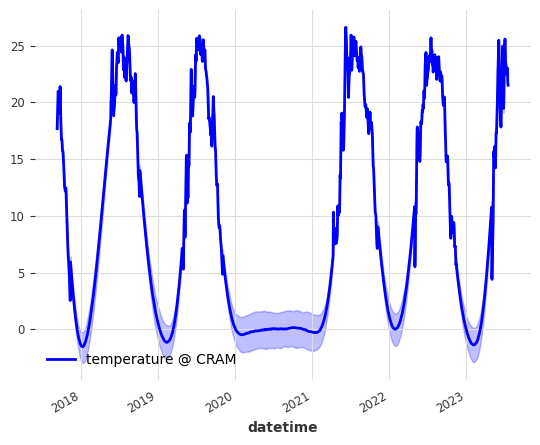

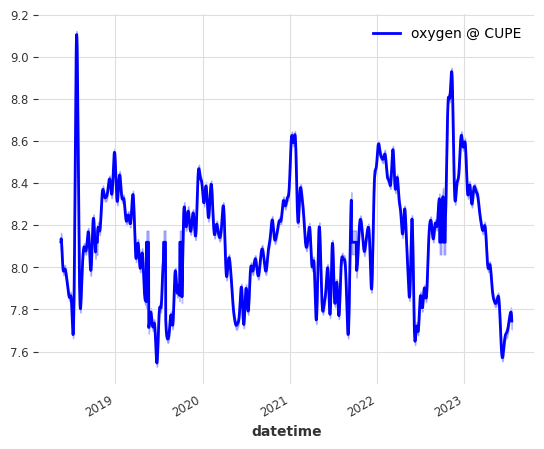

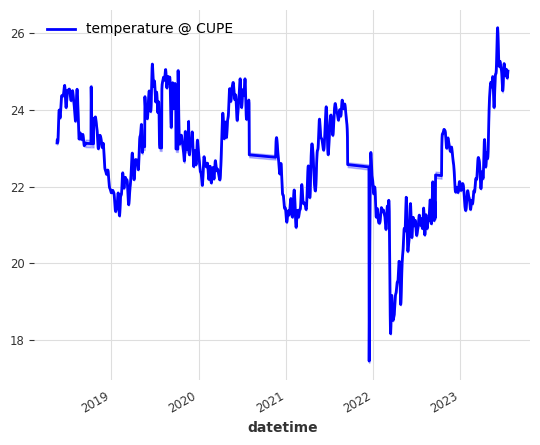

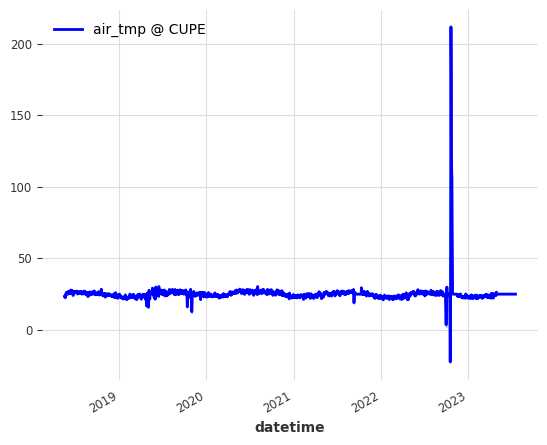

In [5]:
for site in targets["site_id"].unique()[:10]:
    data_preprocessor.plot_by_site(site)

Building a climatology-like forecaster:

In [157]:
from typing import Optional
class HistoricalForecaster():
    def __init__(self,
                 data_preprocessor: Optional = None,
                 output_csv_name: Optional[str] = "historical_forecaster_output.csv",
                 validation_split_date: Optional[str] = None, #YYYY-MM-DD
                 forecast_horizon: Optional[int] = 30,
                 site_id: Optional[str] = None,
                 target_variable: Optional[str] = None,
                 ):
        self.data_preprocessor = data_preprocessor
        self.output_csv_name = output_csv_name
        self.validation_split_date = validation_split_date
        self.forecast_horizon = forecast_horizon
        self.site_id = site_id
        self.target_variable = target_variable
        self._preprocess_data()

    def _preprocess_data(self):
        stitched_series_dict = self.data_preprocessor.sites_dict[self.site_id]
        # If there was failure when doing the GP fit then we can't do preprocessing
        if self.target_variable in \
                self.data_preprocessor.sites_dict_null[self.site_id]:
            return "Cannot fit this target time series as no GP fit was performed."
        self.inputs = stitched_series_dict[self.target_variable]

        # Splitting training and validation set
        self.year = int(self.validation_split_date[:4])
        month = int(self.validation_split_date[5:7])
        day = int(self.validation_split_date[8:])
        split_date = pd.Timestamp(year=self.year, month=month, day=day)
        self.training_set, self.validation_set = self.inputs.split_before(split_date)

    def make_forecasts(self):
        """
        This function finds the historical mean and var, and uses these statistics for
        the forecast
        """
        # Using the medians of the GP filter
        median_df = data_preprocessor.sites_dict[self.site_id]\
                        [self.target_variable].median().pd_dataframe()
        median_df["timestamp"] = pd.to_datetime(median_df.index)
        median_df["day_of_year"] = median_df["timestamp"].dt.dayofyear

        # Computing average and std for doy's 
        doy_df = median_df.groupby(['day_of_year'])['0'].agg(['mean', 'std'])

        # Filtering the previously computed averages and std for our dates of interest
        forecast_doys = pd.date_range(start=self.validation_split_date, 
                                      periods=self.forecast_horizon, 
                                      freq='D').dayofyear
        forecast_df = doy_df.loc[forecast_doys]

        def day_of_year_to_date(year, day_of_year):
            base_date = datetime(year, 1, 1)
            target_date = base_date + timedelta(days=day_of_year - 1)
            return target_date

        date_index = [day_of_year_to_date(self.year, day) for day in forecast_df.index]
        forecast_df.index = date_index
        return forecast_df

In [158]:
model = HistoricalForecaster(data_preprocessor=data_preprocessor,
                 output_csv_name="historical_forecaster_output.csv",
                 validation_split_date="2023-01-01", #YYYY-MM-DD
                 forecast_horizon=30,
                 site_id="BARC",
                 target_variable="oxygen")

In [159]:
x = model.make_forecasts()

In [160]:
x

,mean,std
2023-01-01,8.545159,1.283853
2023-01-02,8.492316,1.251924
2023-01-03,8.550693,1.260642
2023-01-04,8.600294,1.285082
2023-01-05,8.545139,1.286696
2023-01-06,8.446510,1.288542
2023-01-07,8.406135,1.295534
2023-01-08,8.430066,1.303102
2023-01-09,8.457497,1.307546
2023-01-10,8.465723,1.310467


Want to test XGB and DLinear models, which I just added.

In [5]:
linear_forecaster = BaseForecaster(model="Linear",
                                target_variable_column_name="oxygen",
                                data_preprocessor=data_preprocessor,
                                datetime_column_name="datetime",
                                covariates_names=["air_tmp", "chla", "temperature"],
                                output_csv_name="trash.csv",
                                validation_split_date="2023-02-26",
                                model_hyperparameters={'lags': [-x for x in range(1, 181)],
                                                       'lags_past_covariates': [-x for x in range(1, 181)],
                                                       },
                                model_likelihood={"likelihood": "quantile",
                                                  "quantiles": [0.05, 0.5, 0.95]},
                                forecast_horizon=30,
                                site_id="BARC")

In [6]:
import time
start = time.time()
linear_forecaster.make_forecasts()
print(time.time()-start)

{'lags': [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38, -39, -40, -41, -42, -43, -44, -45, -46, -47, -48, -49, -50, -51, -52, -53, -54, -55, -56, -57, -58, -59, -60, -61, -62, -63, -64, -65, -66, -67, -68, -69, -70, -71, -72, -73, -74, -75, -76, -77, -78, -79, -80, -81, -82, -83, -84, -85, -86, -87, -88, -89, -90, -91, -92, -93, -94, -95, -96, -97, -98, -99, -100, -101, -102, -103, -104, -105, -106, -107, -108, -109, -110, -111, -112, -113, -114, -115, -116, -117, -118, -119, -120, -121, -122, -123, -124, -125, -126, -127, -128, -129, -130, -131, -132, -133, -134, -135, -136, -137, -138, -139, -140, -141, -142, -143, -144, -145, -146, -147, -148, -149, -150, -151, -152, -153, -154, -155, -156, -157, -158, -159, -160, -161, -162, -163, -164, -165, -166, -167, -168, -169, -170, -171, -172, -173, -174, -175, -176, -177, -178, -179, -180], 'lags_past_covari

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


1140.064087152481


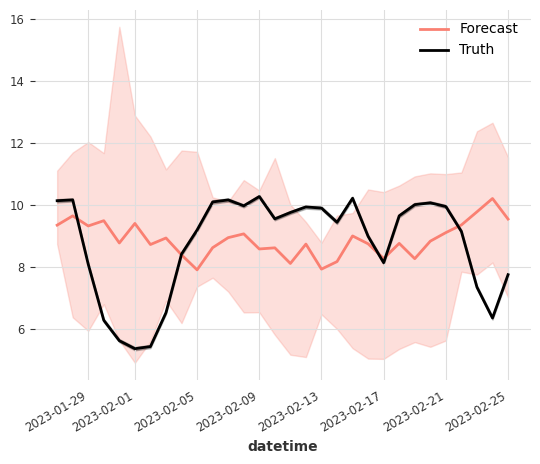

In [61]:
df = pd.read_csv("trash_NLinear.csv")
times = pd.to_datetime(df["datetime"])
times = pd.DatetimeIndex(times)
values = df.loc[:, df.columns!="datetime"].to_numpy().reshape((linear_forecaster.forecast_horizon, 1, -1))
direct_predictions_ts = TimeSeries.from_times_and_values(times, 
                                                         values, 
                                                         fill_missing_dates=True, freq="D")

plt.clf()
direct_predictions_ts.plot(color="salmon", label="Forecast")
nlinear_forecaster.validation_set[:linear_forecaster.forecast_horizon].plot(color="black", label="Truth")
plt.show()

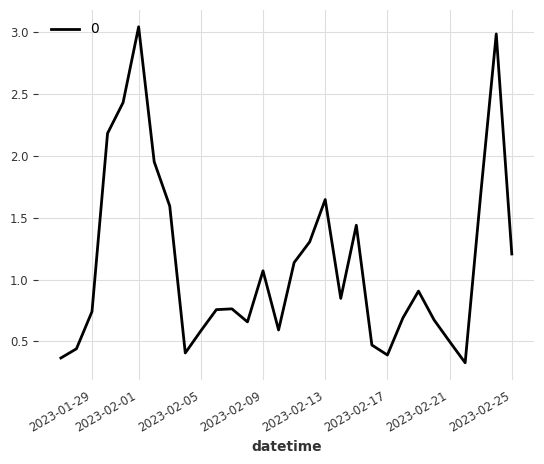

In [64]:
x = crps(direct_predictions_ts, nlinear_forecaster.validation_set[:nlinear_forecaster.forecast_horizon])
plt.clf()
x.plot()
plt.show()

In [63]:
def crps(forecast, ground_truth):
    """
    Returns an array of CRPS scores 
    """
    crps = []
    for i, day_forecast_ in enumerate(forecast):
        # Indexing and transforming forecast and ground truth for each day
        day_ground_truth = ground_truth[i].median().univariate_values()[0]
        day_forecast = day_forecast_.all_values()[0][0]
        n = len(day_forecast)
        crps_day = 0
        for sample in day_forecast:
            crps_lh = 1/n * np.abs(sample - day_ground_truth)
            crps_rh = sum([-1/(2 * n **2) * np.abs(sample - x) for x in day_forecast])

            crps_sample = crps_lh + crps_rh
            crps_day += crps_sample

        crps.append(crps_day)

    crps_ts = TimeSeries.from_times_and_values(forecast.time_index, 
                                               np.array(crps), 
                                               fill_missing_dates=True, freq="D")
    return crps_ts
            

Now, playing with Ray actors as this will be necessary to train models individually for every site.

In [ ]:
block_rnn_forecaster = BaseForecaster.remote(model="BlockRNN",
                                             target_variable_column_name="oxygen",
                                             data_preprocessor=test_preprocessor,
                                             datetime_column_name="datetime",
                                             covariates_names=["air_tmp", "chla", "temperature"],
                                             output_csv_name="trash.csv",
                                             validation_split_date="2023-02-26",
                                             forecast_horizon=30,
                                             site_id="BARC")

Here I tune a Block RNN model. This takes on the order of hours.

In [11]:
from darts.utils.likelihood_models import QuantileRegression

block_rnn_forecaster = BaseForecaster(model="BlockRNN",
                                      target_variable_column_name="oxygen",
                                      data_preprocessor=data_preprocessor,
                                      datetime_column_name="datetime",
                                      covariates_names=["air_tmp", "chla", "temperature"],
                                      output_csv_name="trash.csv",
                                      validation_split_date="2023-02-26",
                                      model_hyperparameters={'input_chunk_length': 180, 
                                                             'hidden_dim': 64, 
                                                             'model': 'GRU', 
                                                             'n_rnn_layers': 3},
                                     model_likelihood={"likelihood": QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95])},
                                     forecast_horizon=30,
                                     site_id="BARC")

In [12]:
block_rnn_forecaster.tune({
    "input_chunk_length": [60, 180, 360, 540],
    "hidden_dim": [16, 32, 64, 126],
    "model": ["RNN", "GRU", "LSTM"],
    "n_rnn_layers": [2, 3, 4, 5],
})

[I 2023-07-25 14:36:01,384] A new study created in memory with name: no-name-9d0a7135-c70d-4fdf-95b4-115583999492
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-25 14:52:45,702] Trial 0 finished with value: 2.4341882551932152 and parameters: {'input_chunk_length': 540, 'hidden_dim': 16, 'model': 'RNN', 'n_rnn_layers': 2}. Best is trial 0 with value: 2.4341882551932152.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-25 15:21:50,630] Trial 1 finished with value: 2.8280642455997516 and parameters: {'input_chunk_length': 360, 'hidden_dim': 64, 'model': 'RNN', 'n_rnn_layers': 4}. Best is trial 0 with value: 2.4341882551932152.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-25 15:50:51,302] Trial 2 finished with value: 3.561555955133798 and parameters: {'input_chunk_length': 360, 'hidden_dim': 64, 'model': 'RNN', 'n_rnn_layers': 4}. Best is trial 0 with value: 2.4341882551932152.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-25 16:27:57,558] Trial 3 finished with value: 6.415455144515607 and parameters: {'input_chunk_length': 540, 'hidden_dim': 32, 'model': 'GRU', 'n_rnn_layers': 3}. Best is trial 0 with value: 2.4341882551932152.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-25 17:53:11,232] Trial 4 finished with value: 6.565132186751398 and parameters: {'input_chunk_length': 360, 'hidden_dim': 126, 'model': 'RNN', 'n_rnn_layers': 5}. Best is trial 0 with value: 2.4341882551932152.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-25 18:07:54,568] Trial 5 finished with value: 2.9428647584163103 and parameters: {'input_chunk_length': 360, 'hidden_dim': 16, 'model': 'RNN', 'n_rnn_layers': 3}. Best is trial 0 with value: 2.4341882551932152.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-25 18:31:55,421] Trial 6 finished with value: 3.4492536834808365 and parameters: {'input_chunk_length': 540, 'hidden_dim': 32, 'model': 'RNN', 'n_rnn_layers': 4}. Best is trial 0 with value: 2.4341882551932152.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-25 18:44:13,876] Trial 7 finished with value: 6.321774867062531 and parameters: {'input_chunk_length': 180, 'hidden_dim': 16, 'model': 'GRU', 'n_rnn_layers': 4}. Best is trial 0 with value: 2.4341882551932152.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-25 19:29:17,487] Trial 8 finished with value: 7.271845837187151 and parameters: {'input_chunk_length': 360, 'hidden_dim': 126, 'model': 'RNN', 'n_rnn_layers': 2}. Best is trial 0 with value: 2.4341882551932152.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-25 19:59:40,097] Trial 9 finished with value: 5.496950380816061 and parameters: {'input_chunk_length': 360, 'hidden_dim': 64, 'model': 'GRU', 'n_rnn_layers': 3}. Best is trial 0 with value: 2.4341882551932152.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-25 20:05:25,382] Trial 10 finished with value: 2.8230707858711694 and parameters: {'input_chunk_length': 60, 'hidden_dim': 16, 'model': 'LSTM', 'n_rnn_layers': 2}. Best is trial 0 with value: 2.4341882551932152.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-25 20:11:11,875] Trial 11 finished with value: 2.6883779679921878 and parameters: {'input_chunk_length': 60, 'hidden_dim': 16, 'model': 'LSTM', 'n_rnn_layers': 2}. Best is trial 0 with value: 2.4341882551932152.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-25 20:16:58,695] Trial 12 finished with value: 6.19967613330368 and parameters: {'input_chunk_length': 60, 'hidden_dim': 16, 'model': 'LSTM', 'n_rnn_layers': 2}. Best is trial 0 with value: 2.4341882551932152.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-25 20:22:45,527] Trial 13 finished with value: 11.175540930402855 and parameters: {'input_chunk_length': 60, 'hidden_dim': 16, 'model': 'LSTM', 'n_rnn_layers': 2}. Best is trial 0 with value: 2.4341882551932152.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-25 20:51:05,805] Trial 14 finished with value: 3.0578662520238833 and parameters: {'input_chunk_length': 540, 'hidden_dim': 16, 'model': 'LSTM', 'n_rnn_layers': 2}. Best is trial 0 with value: 2.4341882551932152.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-25 21:14:48,909] Trial 15 finished with value: 13.28970996545961 and parameters: {'input_chunk_length': 180, 'hidden_dim': 16, 'model': 'LSTM', 'n_rnn_layers': 5}. Best is trial 0 with value: 2.4341882551932152.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-25 21:20:34,890] Trial 16 finished with value: 3.8723631646705683 and parameters: {'input_chunk_length': 60, 'hidden_dim': 16, 'model': 'LSTM', 'n_rnn_layers': 2}. Best is trial 0 with value: 2.4341882551932152.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-25 22:19:10,260] Trial 17 finished with value: 3.010592179895072 and parameters: {'input_chunk_length': 540, 'hidden_dim': 126, 'model': 'RNN', 'n_rnn_layers': 2}. Best is trial 0 with value: 2.4341882551932152.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-25 22:25:37,789] Trial 18 finished with value: 3.8738973502578613 and parameters: {'input_chunk_length': 60, 'hidden_dim': 32, 'model': 'LSTM', 'n_rnn_layers': 2}. Best is trial 0 with value: 2.4341882551932152.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-25 23:12:54,922] Trial 19 finished with value: 4.142051365206891 and parameters: {'input_chunk_length': 540, 'hidden_dim': 16, 'model': 'GRU', 'n_rnn_layers': 5}. Best is trial 0 with value: 2.4341882551932152.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-25 23:25:54,827] Trial 20 finished with value: 2.0158244059609025 and parameters: {'input_chunk_length': 180, 'hidden_dim': 16, 'model': 'LSTM', 'n_rnn_layers': 2}. Best is trial 20 with value: 2.0158244059609025.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-25 23:38:54,099] Trial 21 finished with value: 3.77566219557154 and parameters: {'input_chunk_length': 180, 'hidden_dim': 16, 'model': 'LSTM', 'n_rnn_layers': 2}. Best is trial 20 with value: 2.0158244059609025.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-25 23:51:53,817] Trial 22 finished with value: 2.215490104219674 and parameters: {'input_chunk_length': 180, 'hidden_dim': 16, 'model': 'LSTM', 'n_rnn_layers': 2}. Best is trial 20 with value: 2.0158244059609025.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-26 00:04:54,729] Trial 23 finished with value: 3.655195564828765 and parameters: {'input_chunk_length': 180, 'hidden_dim': 16, 'model': 'LSTM', 'n_rnn_layers': 2}. Best is trial 20 with value: 2.0158244059609025.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-26 00:17:52,836] Trial 24 finished with value: 2.091540410549564 and parameters: {'input_chunk_length': 180, 'hidden_dim': 16, 'model': 'LSTM', 'n_rnn_layers': 2}. Best is trial 20 with value: 2.0158244059609025.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-26 00:30:52,749] Trial 25 finished with value: 2.812388667021594 and parameters: {'input_chunk_length': 180, 'hidden_dim': 16, 'model': 'LSTM', 'n_rnn_layers': 2}. Best is trial 20 with value: 2.0158244059609025.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-26 00:55:35,899] Trial 26 finished with value: 4.620991112048412 and parameters: {'input_chunk_length': 180, 'hidden_dim': 126, 'model': 'LSTM', 'n_rnn_layers': 2}. Best is trial 20 with value: 2.0158244059609025.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-26 01:27:40,808] Trial 27 finished with value: 3.7694071997675604 and parameters: {'input_chunk_length': 180, 'hidden_dim': 64, 'model': 'LSTM', 'n_rnn_layers': 5}. Best is trial 20 with value: 2.0158244059609025.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-26 01:43:04,097] Trial 28 finished with value: 5.393554876887066 and parameters: {'input_chunk_length': 180, 'hidden_dim': 32, 'model': 'LSTM', 'n_rnn_layers': 3}. Best is trial 20 with value: 2.0158244059609025.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-26 01:56:03,296] Trial 29 finished with value: 5.390504660987756 and parameters: {'input_chunk_length': 180, 'hidden_dim': 16, 'model': 'LSTM', 'n_rnn_layers': 2}. Best is trial 20 with value: 2.0158244059609025.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-26 02:09:03,263] Trial 30 finished with value: 1.9715183435891355 and parameters: {'input_chunk_length': 180, 'hidden_dim': 16, 'model': 'LSTM', 'n_rnn_layers': 2}. Best is trial 30 with value: 1.9715183435891355.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-26 02:22:05,083] Trial 31 finished with value: 3.271506388391126 and parameters: {'input_chunk_length': 180, 'hidden_dim': 16, 'model': 'LSTM', 'n_rnn_layers': 2}. Best is trial 30 with value: 1.9715183435891355.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-26 02:35:05,019] Trial 32 finished with value: 3.777602370579842 and parameters: {'input_chunk_length': 180, 'hidden_dim': 16, 'model': 'LSTM', 'n_rnn_layers': 2}. Best is trial 30 with value: 1.9715183435891355.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-26 02:48:04,634] Trial 33 finished with value: 10.534543180127667 and parameters: {'input_chunk_length': 180, 'hidden_dim': 16, 'model': 'LSTM', 'n_rnn_layers': 2}. Best is trial 30 with value: 1.9715183435891355.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-26 03:07:52,755] Trial 34 finished with value: 4.578201507297637 and parameters: {'input_chunk_length': 180, 'hidden_dim': 64, 'model': 'LSTM', 'n_rnn_layers': 4}. Best is trial 30 with value: 1.9715183435891355.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-26 03:19:15,921] Trial 35 finished with value: 1.9071457740446593 and parameters: {'input_chunk_length': 180, 'hidden_dim': 16, 'model': 'GRU', 'n_rnn_layers': 2}. Best is trial 35 with value: 1.9071457740446593.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-26 03:31:04,772] Trial 36 finished with value: 2.643765037221637 and parameters: {'input_chunk_length': 180, 'hidden_dim': 16, 'model': 'GRU', 'n_rnn_layers': 3}. Best is trial 35 with value: 1.9071457740446593.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-26 03:48:58,406] Trial 37 finished with value: 3.5972142642547102 and parameters: {'input_chunk_length': 180, 'hidden_dim': 32, 'model': 'GRU', 'n_rnn_layers': 4}. Best is trial 35 with value: 1.9071457740446593.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-26 04:06:00,045] Trial 38 finished with value: 4.41457294613955 and parameters: {'input_chunk_length': 180, 'hidden_dim': 64, 'model': 'GRU', 'n_rnn_layers': 2}. Best is trial 35 with value: 1.9071457740446593.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-26 04:53:40,108] Trial 39 finished with value: 6.092624764093568 and parameters: {'input_chunk_length': 180, 'hidden_dim': 126, 'model': 'GRU', 'n_rnn_layers': 5}. Best is trial 35 with value: 1.9071457740446593.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-26 05:12:53,520] Trial 40 finished with value: 2.412055535094444 and parameters: {'input_chunk_length': 360, 'hidden_dim': 16, 'model': 'GRU', 'n_rnn_layers': 2}. Best is trial 35 with value: 1.9071457740446593.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-26 05:21:00,985] Trial 41 finished with value: 5.057733656826759 and parameters: {'input_chunk_length': 180, 'hidden_dim': 16, 'model': 'RNN', 'n_rnn_layers': 2}. Best is trial 35 with value: 1.9071457740446593.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-26 05:34:00,096] Trial 42 finished with value: 2.004002406262425 and parameters: {'input_chunk_length': 180, 'hidden_dim': 16, 'model': 'LSTM', 'n_rnn_layers': 2}. Best is trial 35 with value: 1.9071457740446593.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-26 05:45:29,684] Trial 43 finished with value: 4.334582518399747 and parameters: {'input_chunk_length': 180, 'hidden_dim': 16, 'model': 'GRU', 'n_rnn_layers': 2}. Best is trial 35 with value: 1.9071457740446593.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-26 05:59:33,645] Trial 44 finished with value: 3.6496189897294897 and parameters: {'input_chunk_length': 180, 'hidden_dim': 16, 'model': 'LSTM', 'n_rnn_layers': 4}. Best is trial 35 with value: 1.9071457740446593.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-26 06:14:21,555] Trial 45 finished with value: 2.5760728265999355 and parameters: {'input_chunk_length': 360, 'hidden_dim': 16, 'model': 'RNN', 'n_rnn_layers': 3}. Best is trial 35 with value: 1.9071457740446593.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-26 06:27:19,120] Trial 46 finished with value: 16.944069995079353 and parameters: {'input_chunk_length': 180, 'hidden_dim': 16, 'model': 'LSTM', 'n_rnn_layers': 2}. Best is trial 35 with value: 1.9071457740446593.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-26 06:43:43,314] Trial 47 finished with value: 4.724173274919769 and parameters: {'input_chunk_length': 180, 'hidden_dim': 32, 'model': 'GRU', 'n_rnn_layers': 2}. Best is trial 35 with value: 1.9071457740446593.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-26 07:11:59,621] Trial 48 finished with value: 2.336222983298295 and parameters: {'input_chunk_length': 540, 'hidden_dim': 16, 'model': 'LSTM', 'n_rnn_layers': 2}. Best is trial 35 with value: 1.9071457740446593.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-07-26 07:36:41,943] Trial 49 finished with value: 4.560889131611526 and parameters: {'input_chunk_length': 180, 'hidden_dim': 126, 'model': 'LSTM', 'n_rnn_layers': 2}. Best is trial 35 with value: 1.9071457740446593.


Testing BlockRNN

Now, I make forecasts on validation set and do historical backtesting.

In [13]:
block_rnn_forecaster.make_forecasts()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


{'input_chunk_length': 180, 'hidden_dim': 16, 'model': 'RNN', 'n_rnn_layers': 5}


`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


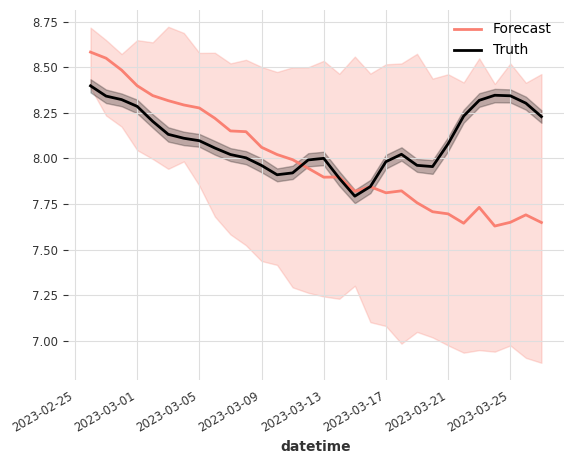

In [14]:
df = pd.read_csv("trash.csv")
times = pd.to_datetime(df["datetime"])
times = pd.DatetimeIndex(times)
values = df.loc[:, df.columns!="datetime"].to_numpy().reshape((block_rnn_forecaster.forecast_horizon, 1, -1))
direct_predictions_ts = TimeSeries.from_times_and_values(times, 
                                                         values, 
                                                         fill_missing_dates=True, freq="D")

plt.clf()
direct_predictions_ts.plot(color="salmon", label="Forecast")
block_rnn_forecaster.validation_set[:block_rnn_forecaster.forecast_horizon].plot(color="black", label="Truth")
plt.show()

In [15]:
block_rnn_forecaster.get_historicals_and_residuals()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), us

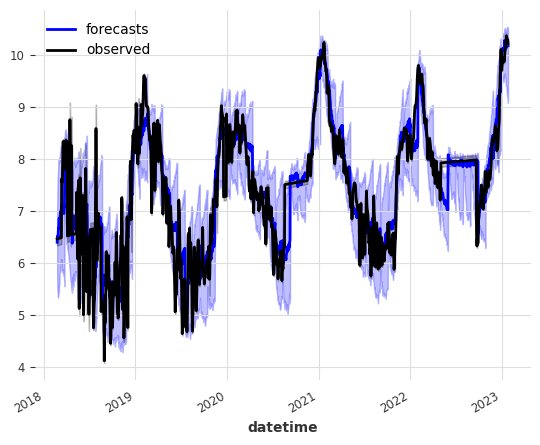

In [18]:
plt.clf()
block_rnn_forecaster.historical_forecasts.plot(color="blue", label="forecasts")
block_rnn_forecaster.historical_ground_truth.plot(color="black", label="observed")
plt.show()

Let's try the same model and hyperparameters but on different target series.

In [22]:
block_rnn_forecaster_chla = BaseForecaster(model="BlockRNN",
                                      data_preprocessor=data_preprocessor,
                                      target_variable_column_name="chla",
                                      datetime_column_name="datetime",
                                      covariates_names=["air_tmp", "oxygen", "temperature"],
                                      output_csv_name="trash_chla.csv",
                                      validation_split_date="2023-02-26",
                                      model_hyperparameters={'input_chunk_length': 180, 
                                                             'hidden_dim': 16, 
                                                             'model': 'RNN', 
                                                             'n_rnn_layers': 5},
                                     forecast_horizon=30,
                                     site_id="BARC")

In [23]:
block_rnn_forecaster_chla.make_forecasts()

{'input_chunk_length': 180, 'hidden_dim': 16, 'model': 'RNN', 'n_rnn_layers': 5}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


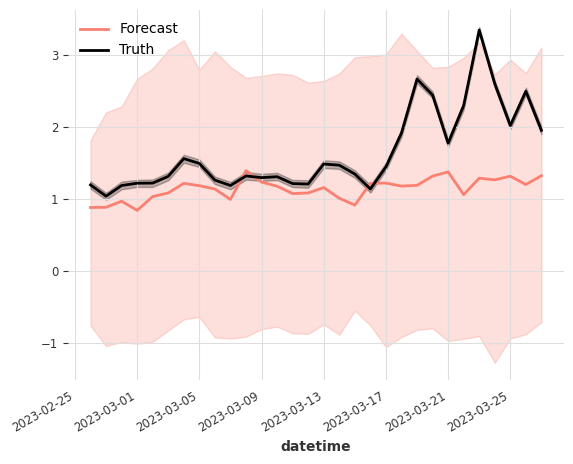

In [24]:
df = pd.read_csv("trash_chla.csv")
times = pd.to_datetime(df["datetime"])
times = pd.DatetimeIndex(times)
values = df.loc[:, df.columns!="datetime"].to_numpy().reshape((block_rnn_forecaster_chla.forecast_horizon, 1, -1))
direct_predictions_ts = TimeSeries.from_times_and_values(times, 
                                                         values, 
                                                         fill_missing_dates=True, freq="D")

plt.clf()
direct_predictions_ts.plot(color="salmon", label="Forecast")
block_rnn_forecaster_chla.validation_set[:block_rnn_forecaster_chla.forecast_horizon].plot(color="black", label="Truth")
plt.show()

Now looking at the historical forecasts

In [25]:
block_rnn_forecaster_chla.get_historicals_and_residuals()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), us

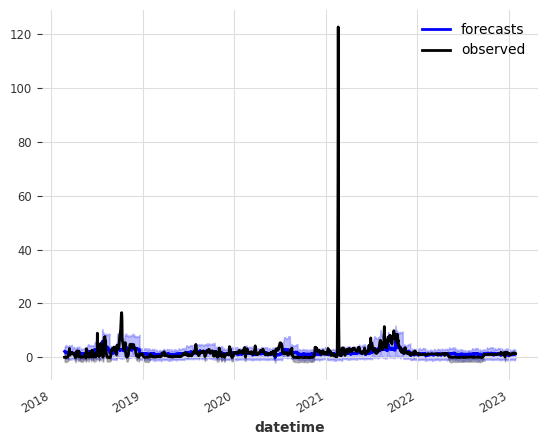

In [26]:
plt.clf()
block_rnn_forecaster_chla.historical_forecasts.plot(color="blue", label="forecasts")
block_rnn_forecaster_chla.historical_ground_truth.plot(color="black", label="observed")
plt.show()

And water temperature

In [27]:
block_rnn_forecaster_wt = BaseForecaster(model="BlockRNN",
                                      data_preprocessor=data_preprocessor,
                                      target_variable_column_name="temperature",
                                      datetime_column_name="datetime",
                                      covariates_names=["air_tmp", "oxygen", "chla"],
                                      output_csv_name="trash_temperature.csv",
                                      validation_split_date="2023-02-26",
                                      model_hyperparameters={'input_chunk_length': 180, 
                                                             'hidden_dim': 16, 
                                                             'model': 'RNN', 
                                                             'n_rnn_layers': 5},
                                      forecast_horizon=30,
                                      site_id="BARC")

In [28]:
block_rnn_forecaster_wt.make_forecasts()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


{'input_chunk_length': 180, 'hidden_dim': 16, 'model': 'RNN', 'n_rnn_layers': 5}


`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


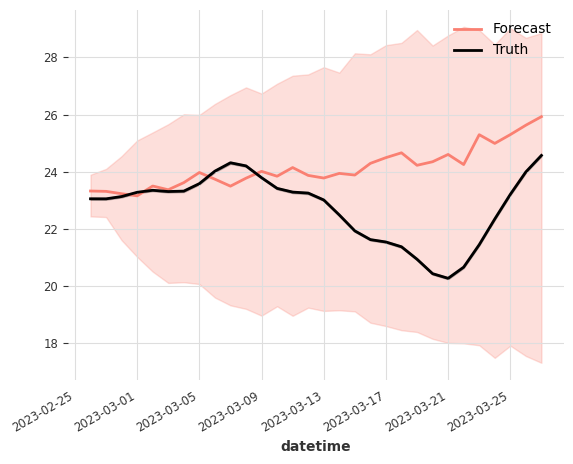

In [29]:
df = pd.read_csv("trash_temperature.csv")
times = pd.to_datetime(df["datetime"])
times = pd.DatetimeIndex(times)
values = df.loc[:, df.columns!="datetime"].to_numpy().reshape((block_rnn_forecaster_wt.forecast_horizon, 1, -1))
direct_predictions_ts = TimeSeries.from_times_and_values(times, 
                                                         values, 
                                                         fill_missing_dates=True, freq="D")

plt.clf()
direct_predictions_ts.plot(color="salmon", label="Forecast")
block_rnn_forecaster_wt.validation_set[:block_rnn_forecaster_wt.forecast_horizon].plot(color="black", label="Truth")
plt.show()

And historicals

In [30]:
block_rnn_forecaster_wt.get_historicals_and_residuals()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), us

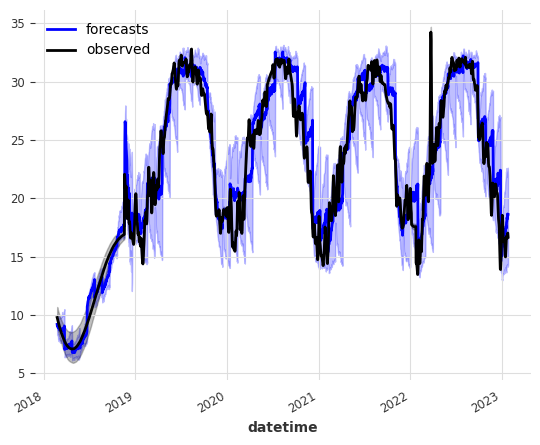

In [31]:
plt.clf()
block_rnn_forecaster_wt.historical_forecasts.plot(color="blue", label="forecasts")
block_rnn_forecaster_wt.historical_ground_truth.plot(color="black", label="observed")
plt.show()

Everything looks pretty good by eye here with the exception of chlorophyll-A, which might take a little bit more handholding. Time to start working on the full pipeline

And N-Linear

In [60]:
nlinear_forecaster = BaseForecaster(model="NLinear",
                                      data_preprocessor=data_preprocessor,
                                      target_variable_column_name="oxygen",
                                      datetime_column_name="datetime",
                                      covariates_names=["air_tmp", "chla", "temperature"],
                                      output_csv_name="trash_NLinear.csv",
                                      validation_split_date="2023-01-27",
                                      model_hyperparameters={'input_chunk_length': 180,
                                                            },
                                     forecast_horizon=30,
                                     site_id="ARIK")

In [48]:
nlinear_forecaster.make_forecasts()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


{'input_chunk_length': 180}


`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


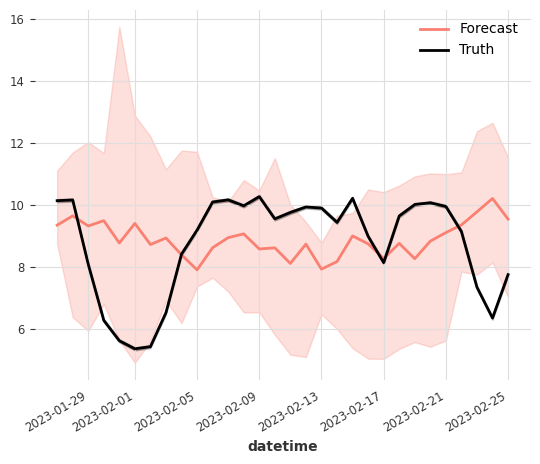

In [49]:
df = pd.read_csv("trash_NLinear.csv")
times = pd.to_datetime(df["datetime"])
times = pd.DatetimeIndex(times)
values = df.loc[:, df.columns!="datetime"].to_numpy().reshape((block_rnn_forecaster.forecast_horizon, 1, -1))
direct_predictions_ts = TimeSeries.from_times_and_values(times, 
                                                         values, 
                                                         fill_missing_dates=True, freq="D")

plt.clf()
direct_predictions_ts.plot(color="salmon", label="Forecast")
block_rnn_forecaster.validation_set[:block_rnn_forecaster.forecast_horizon].plot(color="black", label="Truth")
plt.show()

In [51]:
def read_csv(csv_filename):
    df = pd.read_csv(csv_filename)
    times = pd.to_datetime(df["datetime"])
    times = pd.DatetimeIndex(times)
    values = df.loc[:, df.columns!="datetime"].to_numpy().reshape((block_rnn_forecaster.forecast_horizon, 1, -1))
    direct_predictions_ts = TimeSeries.from_times_and_values(times, 
                                                             values, 
                                                             fill_missing_dates=True, freq="D")

    return direct_predictions_ts

In [52]:
block_rnn_preds = read_csv("trash.csv")
NBEATS_preds = read_csv("trash_NBEATS.csv")
NLinear_preds = read_csv("trash_NLinear.csv")

for preds in [block_rnn_preds, NBEATS_preds, NLinear_preds]:
    smapes = smape(block_rnn_forecaster.validation_set[:block_rnn_forecaster.forecast_horizon],
              preds,
              n_jobs=-1, 
              verbose=False)
    print(np.mean(smapes))

15.486643966411945
16.796052857085364
18.593433992310956


Now will try residual correction to see if that leads to better forecasts

In [53]:
for forecaster in [block_rnn_forecaster, nlinear_forecaster, nbeats_forecaster]:
    forecaster.get_historicals_and_residuals()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), us

In [54]:
# Lets add residual samples to median forecast! then check the smape of that

In [58]:
residual_forecasters = {}
forecasters = {"block": block_rnn_forecaster, "nlinear": nlinear_forecaster, "nbeats": nbeats_forecaster}
for name, object in forecasters.items():
    residual_forecaster = ResidualForecasterDarts(
        historical_forecasts=object.historical_forecasts,
        historical_ground_truth=object.historical_ground_truth,
        covariates=object.covariates,
        validation_split_date="2022-12-28",
        output_csv_name = f"{name}_residual_forecaster.csv",
        forecast_horizon=7
    )
    residual_forecaster.make_residual_forecasts()
    residual_forecasters[name] = residual_forecaster
    

{'input_chunk_length': 180}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


{'input_chunk_length': 180}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


{'input_chunk_length': 180}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


In [91]:
start_date = pd.Timestamp(year=2022, month=12, day=28)
end_date = pd.Timestamp(year=2023, month=1, day=3)
historical_forecast = block_rnn_forecaster.historical_forecasts.slice(start_date, end_date)
historical_ground_truth = block_rnn_forecaster.historical_ground_truth.slice(start_date, end_date)

In [78]:
direct_csv_names = {"block": "trash.csv", "nlinear": "trash_NLinear.csv", "nbeats": "trash_NBEATS.csv"}
direct_predictions = {}

for name, csv in direct_csv_names.items():
    df = pd.read_csv(f"{csv}")
    times = pd.to_datetime(df["datetime"])
    times = pd.DatetimeIndex(times)
    values = df.loc[:, df.columns!="datetime"].to_numpy().reshape((forecasters[name].forecast_horizon, 1, -1))
    direct_predictions_ts = TimeSeries.from_times_and_values(times, 
                                                             values, 
                                                             fill_missing_dates=True, freq="D")
    direct_predictions[name] = direct_predictions_ts

In [79]:
def stack_ts(timeseries, n_samples=500):
    output = timeseries.copy()
    for i in range(n_samples-1):
        output = output.concatenate(timeseries, axis=2)
    return output

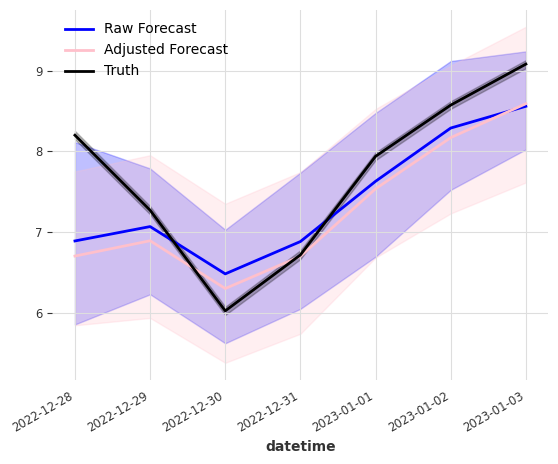

In [92]:
df = pd.read_csv("block_residual_forecaster.csv")
times = pd.to_datetime(df["datetime"])
times = pd.DatetimeIndex(times)
values = df.loc[:, df.columns!="datetime"].to_numpy().reshape((residual_forecasters["block"].forecast_horizon, 1, -1))
residuals = TimeSeries.from_times_and_values(times, 
                                             values, 
                                             fill_missing_dates=True, freq="D")
medians = stack_ts(historical_forecast.quantile_timeseries(0.5))
plt.clf()
historical_forecast.plot(color="blue", label="Raw Forecast")
(medians+residuals).plot(color="pink", label="Adjusted Forecast")
historical_ground_truth.plot(color="black", label="Truth")
plt.show()